**Montando el Drive para obtener dataset y dependencias de paquetes**

In [ ]:
from google.colab import drive
import sys, os

In [ ]:
drive.mount('/content/drive')

BASE_DIR      = '/content/drive/MyDrive/DSP_Alvaro_Esparza'
NOTEBOOKS_DIR = os.path.join(BASE_DIR, 'Notebooks')

DEPS_DIR = os.path.join(BASE_DIR, 'Dependencias')

for path in [NOTEBOOKS_DIR, DEPS_DIR]:
    if os.path.isdir(path) and path not in sys.path:
        sys.path.append(path)

print("Rutas en sys.path relevantes:")
print(" -", NOTEBOOKS_DIR, "(Notebooks)")
print(" -", DEPS_DIR, "(Dependencias, si existe)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Rutas en sys.path relevantes:
 - /content/drive/MyDrive/DSP_Alvaro_Esparza/Notebooks (Notebooks)
 - /content/drive/MyDrive/DSP_Alvaro_Esparza/Dependencias (Dependencias, si existe)


**No se corren (Solo una vez para tener las dependencias en una carpeta)**

In [ ]:
#Actualiza pip (rápido) y satisface jedi (el warning típico de IPython)
#%pip -q install --upgrade pip
#%pip -q install --target="$DEPS_DIR" "jedi>=0.18.0" --no-warn-conflicts

In [ ]:
#%pip install --target="$DEPS_DIR" torchviz==0.0.2 --no-warn-conflicts

In [ ]:
#%pip install --target="$DEPS_DIR" tqdm --no-warn-conflicts

In [ ]:
#%pip install --target="$DEPS_DIR" netcal==1.3.6 --no-warn-conflicts

In [ ]:
#%pip install --target="$DEPS_DIR" --no-warn-conflicts "grad-cam>=1.3.6" "opencv-python-headless<5"

In [ ]:
#Dependencia de sistema para torchviz (persistente NO es; hay que ponerla en cada sesion)
!apt-get -qq update
!apt-get -qq install -y graphviz

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


# **Importando librerías y datos**

Glosario de librerías (funciones y métodos)
--------------------------------------------------------------------------------
* ast -> Convierte strings que representan estructuras en unas reales
* collections.Counter → Conteo de frecuencias (clases, etiquetas).
* copy -> Copiar objetos complejos
* drive -> Para poder entrar a Google Drive
* glob -> Búsqueda de rutas por patrones
* graphviz.Digraph → Construir y renderizar grafos (arquitecturas y flujos)
* gradcam_utils (GradCAM, overlay_cam_on_pil) → Grad-CAM y superposición sobre PIL
* IPython.display (ImageL, display) → Mostrar imágenes/objetos en notebooks.
* json → Serialización/lectura de JSON
* detector_unet (UNetMini, unet_infer_box, letterbox_resize) → Segmentación/ROI y utilidades de resize letterbox
* math -> Usado principalmente para tratar nulos
* matplotlib.cm -> Mapas de color para escalas/heatmaps
* matplotlib.pyplot -> Para graficar
* numpy -> Cálculo numérico y arreglos
* os -> Para interactuar con el sistema de archivos
* pandas -> Manipulación de datos tabulares
* pathlib.Path -> Manejo de rutas y archivos
* PIL.Image -> Cargar imágenes
* PIL.ImageDraw / ImageFont → Dibujar y anotar sobre imágenes; manejar tipografías
* random -> Aleatoridad (semillas)
* sklearn.metrics -> Métricas, curvas ROC/PR y matriz de confusión
* sklearn.model_selection.StratifiedGroupKFold / train_test_split → K-Fold estratificado por grupos y partición hold-out
* sys -> Otorga acceso a variables usadas por el intérprete y funciones que intractúan fuertemente con este
* torch -> Biblioteca principal para DL, tensores y modelos de redes neuronales
* toch.nn -> Contiene componentes para construir redes neuronales
* torch.nn.functional -> API funcional (activaciones, pérdidas, convs, etc.)
* torch.optim -> Contiene los optimizadores para actualizar los parámetros del modelo
* torch.optim.lr_scheduler -> Disminuye la tasa de aprendizaje de manera programada
* torch.utils.data.DataLoader -> Carga datos por lotes
* torch.utils.data.Dataset -> Clase base para datasets personalizados
* torch.utils.data.Subset -> Vista recortada del dataset
* torch.utils.data.WeightedRandomSampler -> Corrige clases desbalanceadas
* torchsummary.summary -> Resumen de capas, params y shapes del modelo.
* torchvision.models -> Modelos pre entrenados y CNNs
* torchvision.transforms -> Para el pre procesamiento de imagenes (Compose, Resize y ToTensor)
* torchviz.make_dot -> Graficar el grafo computacional de PyTorch
* tqdm -> Barra de progreso usada en bucles
* xml.etree.ElementTree -> Procesar meta data en XML

In [ ]:
import ast
from collections import Counter
import copy
from detector_unet import UNetMini, unet_infer_box, letterbox_resize
import glob
from graphviz import Digraph
from gradcam_utils import GradCAM, overlay_cam_on_pil
from IPython.display import Image as ImageL, display
import json
import math
from matplotlib import cm as mpl_cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import random
from sklearn.metrics import (precision_score, recall_score,
                             average_precision_score, balanced_accuracy_score,
                             accuracy_score, f1_score, roc_auc_score, roc_curve,
                             auc as sk_auc, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_curve)
from sklearn.model_selection import (train_test_split, StratifiedGroupKFold)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import (Dataset, DataLoader, Subset,
                              WeightedRandomSampler)
from torchsummary import summary
from torchvision import transforms, models
from torchvision.transforms import Compose, Resize, ToTensor
from torchviz import make_dot
from tqdm import tqdm
import xml.etree.ElementTree as ET

In [ ]:
PROJ_DIR = '/content/drive/MyDrive/DSP_Alvaro_Esparza/Notebooks'
sys.path.append(PROJ_DIR)

In [ ]:
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet     = UNetMini(in_ch = 1, out_ch = 1, base = 16, depth = 4).to(device).eval()

PTH_DIR  = '/content/drive/MyDrive/DSP_Alvaro_Esparza/pths'  # carpeta de pesos
UNET_PTH = os.path.join(PTH_DIR, 'unet_best.pth') # Consiguiendo la mini U-Net

# Carpeta específica para los .pth de DenseNet121
VFINAL_DIR = os.path.join(PTH_DIR, 'ResNet18')
os.makedirs(VFINAL_DIR, exist_ok=True)

def try_load_unet(model, path):
    if os.path.exists(path):
        obj = torch.load(path, map_location=device, weights_only=False)
        state = obj.get('state_dict', obj) if isinstance(obj, dict) else obj
        model.load_state_dict(state, strict=True)
        print(f'U-Net cargada desde: {path}')
        return True
    else:
        cand = sorted(glob.glob(os.path.join(PTH_DIR, 'unet_best*.pth')))
        if cand:
            obj = torch.load(cand[0], map_location = device, weights_only = False)
            state = obj.get('state_dict', obj) if isinstance(obj, dict) else obj
            model.load_state_dict(state, strict=True)
            print(f'U-Net cargada desde: {cand[0]}')
            return True
        print(f'No se encontraron pesos en: {path} ni variantes unet_best*.pth en {PTH_DIR}')
        return False

have_unet = try_load_unet(unet, UNET_PTH)

U-Net cargada desde: /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/unet_best.pth


# **Clases para construir el DataFrame**



In [ ]:
def build_dataset_dataframe(data_dir):
    ''' Se usa para el de kaggle '''
    data = []
    # Contador para saber cuantas dual panes se omiten
    dual_pane_marks_skipped = 0

    for file in os.listdir(data_dir):
        if not file.endswith('.xml'):
            continue # Si no es xml, pasa a la siguiente iteracion

        case_id = file.replace('.xml', '')  # ID del paciente
        xml_path = os.path.join(data_dir, file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        tirads = root.findtext('tirads')
        if tirads is None:
            continue # Salto la iteracion si no hay, pues se usa TIRADS para 0/1

        # Se queda solo con el numero de la escala
        tirads_clean = tirads.lower().replace('tirads', '').replace(' ', '')
        if (not tirads_clean or len(tirads_clean) == 0
            or not tirads_clean[0].isdigit()):
           continue

        label = 1 if int(tirads_clean[0]) >= 4 else 0  # Lo que se va a predecir

        # Otros datos clinicos como campos
        fields = {
            'composition': root.findtext('composition'),
            'echogenicity': root.findtext('echogenicity'),
            'margins': root.findtext('margins'),
            'calcifications': root.findtext('calcifications'),
            'age': root.findtext('age'),
            'sex': root.findtext('sex'),
        }

        # Procesar cada imagen marcada en el XML
        # mark es para cada imagen que hay del paciente
        # svg para los panes dentro de cada imagen
        for mark in root.findall('mark'):
            img_idx = mark.findtext('image')
            img_name = f"{case_id}_{img_idx}.jpg"
            # Se consigue la imagen relacionada al mark
            img_path = os.path.join(data_dir, img_name)

            svg = mark.findtext('svg')
            if not os.path.exists(img_path) or svg is None:
                continue # No existe la imagen o esta no tiene ningun svg
            try:
                regions = ast.literal_eval(svg)
            except:
                continue

            # Si 'regions' es una lista y tiene más de 1 elemento,
            # es una imagen de pantalla dividida (como 62_1.jpg).
            # se omite para evitar fallos en U-Net/Center-Crop.
            if isinstance(regions, list) and len(regions) > 1:
                dual_pane_marks_skipped += 1
                continue # Salta esta <mark> y no anhade sus regiones al dataset

            for i, region in enumerate(regions): # Coordenadas de las regiones
                points = region.get('points', [])
                if not points:
                    continue
                xs = [p['x'] for p in points]
                ys = [p['y'] for p in points]
                xmin, xmax = min(xs), max(xs)
                ymin, ymax = min(ys), max(ys)

                data.append({
                    'img_name': img_name,
                    'img_path': img_path,
                    # Etiqueta unica por region del nodulo
                    'region_id': f"{img_name}_r{i+1}",
                    'box': (xmin, ymin, xmax, ymax), # De la region encerrada
                    'case_id': case_id, # ID del paciente
                    'tirads': tirads_clean, # Escala numerica
                    'label': label, # Benigno o maligno
                    **fields
                })
    if dual_pane_marks_skipped > 0:
        print(f"BuildDF: Se omitieron {dual_pane_marks_skipped} marcas de imagen (tipo dual-pane) para evitar fallos en U-Net/Center-Crop.")
    return pd.DataFrame(data)

In [ ]:
def build_kaggle_dataframe(kaggle_dir):
    df_kaggle = build_dataset_dataframe(kaggle_dir)

    # Anhade las columnas que faltan, con valores por defecto
    if "img_name" not in df_kaggle.columns:
        df_kaggle["img_name"] = df_kaggle["img_path"].apply(lambda p: os.path.basename(str(p)))
    df_kaggle["source"] = "OLD"
    if "official_split" not in df_kaggle.columns:
        df_kaggle["official_split"] = None

    # Asegurar columnas del esquema
    for c in UNIFIED_COLS:
        if c not in df_kaggle.columns: df_kaggle[c] = None
    return df_kaggle[UNIFIED_COLS]

In [ ]:
UNIFIED_COLS = [
    "img_name","img_path","source","case_id","region_id","label","box","official_split",
    "tirads","composition","echogenicity","margins","calcifications","shape","age","sex"
]

def _normalize_label(x):
    if x is None: return None
    if isinstance(x, (int,float)):
        v = int(x);
        return 1 if v==1 else 0
    s = str(x).strip().lower()
    if s in {"1","malignant","maligno","cancer","positive"}: return 1
    if s in {"0","benign","benigno","negative"}: return 0
    try: return int(s)
    except: return None

def build_tn5000_dataframe(tn_root, split_dir=None):
    """
    Lee TN5000 y devuelve un DataFrame compatible con el pipeline.
    - label:   <object><name>  (0=benigno, 1=maligno)
    - box:     <bndbox> (xmin,ymin,xmax,ymax)
    - splits:  train/val/test (.txt)
    """
    img_dir = os.path.join(tn_root, "JPEGImages")
    ann_dir = os.path.join(tn_root, "Annotations")
    if split_dir is None:
        split_dir = os.path.join(tn_root, "ImageSets", "Main")

    def _read_ids(p):
        if not os.path.exists(p): return set()
        with open(p, 'r', encoding='utf-8') as fh:
            return set(x.strip() for x in fh if x.strip())

    # train, test y train/validation
    tr = _read_ids(os.path.join(split_dir, "train.txt"))
    va = _read_ids(os.path.join(split_dir, "val.txt"))
    te = _read_ids(os.path.join(split_dir, "test.txt"))

    rows = []
    for xml_name in os.listdir(ann_dir):
        if not xml_name.endswith(".xml"):
            continue
        xml_path = os.path.join(ann_dir, xml_name)
        root = ET.parse(xml_path).getroot()

        # nombre de imagen
        filename = root.findtext("filename")
        base = filename if filename else os.path.splitext(xml_name)[0] + ".jpg"
        img_path = os.path.join(img_dir, base)
        if not os.path.exists(img_path):
            continue

        obj = root.find("object")
        if obj is None:
            continue

        # etiqueta 0/1
        raw = obj.findtext("name")
        label = _normalize_label(raw)

        # bbox
        b = obj.find("bndbox")
        box = None
        if b is not None:
            xmin = float(b.findtext("xmin")); ymin = float(b.findtext("ymin"))
            xmax = float(b.findtext("xmax")); ymax = float(b.findtext("ymax"))
            box = (xmin, ymin, xmax, ymax)

        img_id = os.path.splitext(base)[0]
        split = "test" if img_id in te else ("val" if img_id in va else ("train" if img_id in tr else None))

        rows.append({
            "img_name": base,
            "img_path": img_path,
            "source": "TN5000",
            "case_id": img_id,              # aqui cada imagen - caso es 1:1
            "region_id": f"{img_id}_bb1",   # una ROI por imagen
            "label": label,
            "box": box,
            "official_split": split,
            # TN5000 no trae clinicos -> None
            "tirads": None, "composition": None, "echogenicity": None, "margins": None,
            "calcifications": None, "shape": None, "age": None, "sex": None
        })
    df = pd.DataFrame(rows)
    for c in UNIFIED_COLS:
        if c not in df.columns: df[c] = None
    return df[UNIFIED_COLS]

# **Clases para generar dataset**

In [ ]:
def _parse_box_maybe(box, W, H):
    """Acepta tuplas/listas o string; maneja normalizado [0,1] o pixeles; valida y recorta a imagen."""
    if box is None:
        return None
    if isinstance(box, str):
        box = box.strip()
        if not box or box.lower() in ('nan','none','null'):
            return None
        try:
            box = ast.literal_eval(box)
        except Exception:
            return None
    if not hasattr(box, '__len__') or len(box) != 4:
        return None
    x0,y0,x1,y1 = map(float, box)
    if max(x0,x1,y0,y1) <= 1.0:
        x0,x1 = x0*W, x1*W; y0,y1 = y0*H, y1*H
    x0 = max(0, min(int(round(x0)), W-1))
    y0 = max(0, min(int(round(y0)), H-1))
    x1 = max(x0+1, min(int(round(x1)), W))
    y1 = max(y0+1, min(int(round(y1)), H))
    if (x1-x0) < 5 or (y1-y0) < 5:
        return None
    return (x0,y0,x1,y1)

# Fallback (incluso sin U-Net)
def resize_center_crop_pil(pil_img, resize_to=256, crop_size=224):
    w,h = pil_img.size
    if w <= h:
        new_w,new_h = resize_to, int(h*resize_to/w)
    else:
        new_h,new_w = resize_to, int(w*resize_to/h)
    img_res = pil_img.resize((new_w,new_h), Image.BILINEAR)
    left = (new_w - crop_size)//2
    top  = (new_h - crop_size)//2
    return img_res.crop((left, top, left+crop_size, top+crop_size))

class NoduleFromDataFrameDataset(Dataset):
    def __init__(self, dataframe, transform=None,
                 detector=None, detector_device=None,
                 seg_min_area=80, seg_margin=0.10):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.detector = detector
        self.detector_device = detector_device
        self.seg_min_area = seg_min_area
        self.seg_margin   = seg_margin

        # Meta-data
        self.cat_fields = ['composition','echogenicity','margins','calcifications','sex']
        self.num_fields = ['age']
        self.cat_maps = {
           col: {val:i for i,val in enumerate(self.df[col].dropna().unique())}
           for col in self.cat_fields
        }

    def encode_clinical(self, row):
        features = []
        for col in self.cat_fields:
            try:
                features.append(self.cat_maps[col][row[col]])
            except:
                features.append(0)
        for col in self.num_fields:
            try:
                features.append(float(row[col]))
            except:
                features.append(0.0)
        return torch.tensor(features, dtype=torch.float32)

    def __len__(self): return len(self.df)

    def get_box_and_source(self, idx, use_detector=True):
        """
        Devuelve: (full_img_PIL_L, box_tuple_o_None, source_str)
          source_str ∈ {'meta', 'unet', 'center'}
        """
        row = self.df.iloc[idx]
        full = Image.open(row['img_path']).convert('L')
        W, H = full.size

        # ROI de metadata
        box = row.get('box', None)
        if isinstance(box, str):
            try: box = ast.literal_eval(box)
            except: box = None
        if box is not None:
            x0,y0,x1,y1 = map(float, box)
            if max(x0,x1,y0,y1) <= 1.0:
                x0,x1 = x0*W, x1*W; y0,y1 = y0*H, y1*H
            x0 = max(0,int(round(x0))); y0 = max(0,int(round(y0)))
            x1 = min(W,int(round(x1))); y1 = min(H,int(round(y1)))
            return full, (x0,y0,x1,y1), 'meta'

        # ROI por U-Net
        if use_detector and (self.detector is not None):
            device = self.detector_device or next(self.detector.parameters()).device
            box_pred, _, _ = unet_infer_box(
                self.detector, full, device=device,
                min_area=getattr(self, 'seg_min_area', 80),
                margin=getattr(self, 'seg_margin', 0.10),
            )
            if box_pred is not None:
                return full, box_pred, 'unet'

        # Fallback: center-crop
        return full, None, 'center'

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Cargar frame completo en escala de grises (pipeline)
        full = Image.open(row['img_path']).convert('L')
        W,H = full.size

        # ROI preferida: la del DF; si no hay, intentar U-Net
        box = _parse_box_maybe(row.get('box', None), W, H)
        if box is None and self.detector is not None:
            try:
                box_pred, _, _ = unet_infer_box(self.detector, full, device=self.detector_device or next(self.detector.parameters()).device,
                                                min_area=self.seg_min_area, margin=self.seg_margin)
                box = _parse_box_maybe(box_pred, W, H)
            except Exception:
                box = None

        # Recorte + Resize(256)+CenterCrop(224) (consistencia con training)
        if box is not None:
            crop = full.crop(box).convert('RGB')
        else:
            crop = full.convert('RGB')  # fallback center-crop si no hay ROI
        pil_224 = resize_center_crop_pil(crop, 256, 224)

        # Transformaciones (train/test)
        if self.transform:
            image = self.transform(pil_224)
        else:
            # por compatibilidad si se dejo un transform basico
            image = transforms.ToTensor()(pil_224)

        clinical = self.encode_clinical(row)
        label = torch.tensor(row['label'], dtype=torch.float32)
        region_id = row['region_id']
        return image, clinical, label, region_id

# **Clase para el ruido moteado**

In [ ]:
class SpeckleNoiseTransform(object):
    def __init__(self, noise_level=0.05):
        self.noise_level = noise_level

    def __call__(self, img):
        #img es un tensor [C, H, W] en [0,1] si ya esta en ToTensor
        noise = torch.randn_like(img) * self.noise_level
        #Ruido proporcional al valor de pixel → afecta mas a regiones brillantes
        return img + img * noise

# **Clase para definir el clasificador multimodelo**

In [ ]:
class MultimodalThyroidClassifier(nn.Module):
    def __init__(self, tabular_input_dim, num_classes=1, dropout_p=0.3):
        super().__init__()

        # --- ResNet-18 preentrenada ---
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Congelar todo
        for param in self.cnn.parameters():
            param.requires_grad = False
        # y descongelar solo layer4
        for name, p in self.cnn.named_parameters():
            if name.startswith("layer4"):
                p.requires_grad = True

        # Usar embedding (quitar FC layer)
        self.cnn.fc = nn.Identity()

        # Se guarda la dimension tabular y un buffer de ceros para cuando falten metadatos
        self.tab_dim = int(tabular_input_dim)
        self.register_buffer("_zeros_tab", torch.zeros(1, self.tab_dim))

        # Red para procesar datos clinicos
        self.tabular_net = nn.Sequential(
            nn.Linear(self.tab_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        tab_out_dim = 32

        # Dimension de salida del backbone (ResNet18 → 512)
        cnn_out_dim = self.cnn.layer4[1].conv2.out_channels

        # Clasificador sobre la fusion imagen + clinico
        self.classifier = nn.Sequential(
            nn.Linear(cnn_out_dim + tab_out_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, num_classes)  # 1 logit: benigno/maligno
        )

    def forward(self, imgs, clinical):
        """
        imgs:     Tensor [B, 3, 224, 224]
        clinical: Tensor [B, tab_dim] | [tab_dim] | None
        devuelve: Tensor [B, 1]
        """
        # Caracteristicas de imagen
        img_feat = self.cnn(imgs)  # [B, 512]
        B = img_feat.size(0)
        dev = img_feat.device
        dt = img_feat.dtype

        # --- Robustez a None/formas/dispositivo/dtype ---
        if clinical is None:
            # Sin metadatos: vector de ceros del tamanho correcto, expandido al batch
            clinical = self._zeros_tab.to(dev, dtype=dt).expand(B, -1)
        else:
            if clinical.dim() == 1:
                clinical = clinical.unsqueeze(0)  # [F] -> [1, F]
            # Ajustar batch: si viene [1, F] y B > 1, se expande; si viene mas grande, se recorta
            if clinical.size(0) == 1 and B > 1:
                clinical = clinical.expand(B, -1)
            elif clinical.size(0) != B:
                clinical = clinical[:B, ...]  # recorta de forma conservadora

            # Ajustar dimension de caracteristicas: pad con ceros o recorta
            if clinical.size(1) < self.tab_dim:
                pad = self.tab_dim - clinical.size(1)
                clinical = F.pad(clinical, (0, pad))  # pad a la derecha
            elif clinical.size(1) > self.tab_dim:
                clinical = clinical[:, :self.tab_dim]

            # Alinear device/dtype
            if clinical.device != dev or clinical.dtype != dt:
                clinical = clinical.to(dev, dtype=dt)

        # Rama tabular
        clinical_feat = self.tabular_net(clinical)  # [B, 32]

        # Fusion
        fused = torch.cat((img_feat, clinical_feat), dim=1)

        # Clasificador final
        output = self.classifier(fused)  # [B, 1]
        return output

Gráfico del flujo del modelo

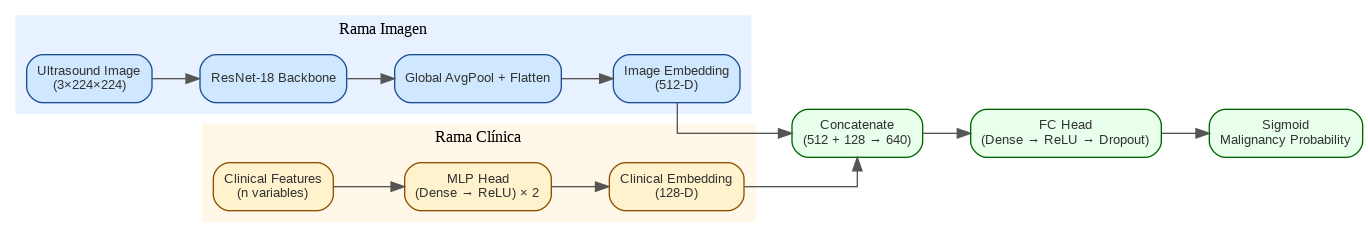

In [ ]:
dot = Digraph("MultimodalThyroidClassifier_Flow", format="png")
dot.attr(rankdir="LR", splines="ortho", bgcolor="white")
dot.attr("node", shape="box", style="rounded,filled", fontname="Helvetica",
         fontsize="10", color="#555555", fontcolor="#333333")
dot.attr("edge", color="#555555")

#Rama imagen
with dot.subgraph(name="cluster_image") as img:
    img.attr(label="Rama Imagen",style="filled",color="#E8F1FF",fontsize="12")
    img.node_attr.update(fillcolor="#D0E8FF", color="#1C4D91")
    img.node("img_in",  "Ultrasound Image\n(3×224×224)")
    img.node("resnet",  "ResNet‑18 Backbone")
    img.node("gap",     "Global AvgPool + Flatten")
    img.node("img_emb", "Image Embedding\n(512‑D)")
    img.edges([("img_in", "resnet"), ("resnet", "gap"), ("gap", "img_emb")])

#Rama Clinica
with dot.subgraph(name="cluster_clinical") as clin:
    clin.attr(label="Rama Clínica",style="filled",color="#FFF7E8",fontsize="12")
    clin.node_attr.update(fillcolor="#FFF3CD", color="#8A4F00")
    clin.node("clin_in",  "Clinical Features\n(n variables)")
    clin.node("mlp",      "MLP Head\n(Dense → ReLU) × 2")
    clin.node("clin_emb", "Clinical Embedding\n(128‑D)")
    clin.edges([("clin_in", "mlp"), ("mlp", "clin_emb")])

#Fusion y clasificacion
dot.node("concat", "Concatenate\n(512 + 128 → 640)", fillcolor="#E8FFEB",
         color="#006400")
dot.node("fc", "FC Head\n(Dense → ReLU → Dropout)", fillcolor="#E8FFEB",
         color="#006400")
dot.node("sigmoid", "Sigmoid\nMalignancy Probability", fillcolor="#E8FFEB",
         color="#006400")
dot.edge("img_emb", "concat")
dot.edge("clin_emb", "concat")
dot.edge("concat", "fc")
dot.edge("fc", "sigmoid")

#Mostrar el grafico en el notebook
png_bytes = dot.pipe(format="png")
display(ImageL(png_bytes))

# **Clase para el early stopping**

In [ ]:
class EarlyStopping: # Evita el overfitting al detener prematuramente
    # Si la metrica no mejora en 3 epocas seguidas, se detiene
    def __init__(self, patience=3, mode="max"):
        self.patience, self.mode = patience, mode
        self.best_val, self.counter, self.best_wts = None, 0, None
        self.stop = False
    def __call__(self, current_val, model):
        better = (
            self.best_val is None or
            (self.mode == 'max' and current_val > self.best_val) or
            (self.mode == 'min' and current_val < self.best_val)
        )
        if better:
            self.best_val = current_val # Actualiza el mejor valor
            self.counter = 0
            # Copia los pesos del modelo en el mejor caso
            self.best_wts = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1 # Actualiza cuantas epocas sin mejora van
            if self.counter >= self.patience:
                self.stop = True # Se detiene

# **Funcion de entrenamiento por folds**

In [ ]:
def train_fold(train_sub_idx, val_sub_idx, fold):
    train_ds = Subset(dataset, train_sub_idx)
    val_ds   = Subset(dataset, val_sub_idx)
    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform   = test_transform

    #Medir el desbalance propio de clases de cada fold
    labels_fold = df.iloc[train_sub_idx].label.values #Etiquetas de este fold
    n_pos = (labels_fold == 1).sum()
    n_neg = (labels_fold == 0).sum()

    #La BCE multiplica el término de la clase 1 por pos_weight
    #Hace que un falso negativo cueste 5 × más que un falso positivo
    pos_weight = torch.tensor([n_neg / n_pos], device=device)

    label_list = [train_ds[i][2].item() for i in range(len(train_ds))]
    #Peso de 1 si label=0 y peso calculado si label=1 (porque hay mas)
    sample_weights = [1.0 if l == 0 else n_neg / n_pos for l in label_list]
    sampler = WeightedRandomSampler(sample_weights,
                                    num_samples=len(sample_weights),
                                    replacement=True)

    train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

    model = MultimodalThyroidClassifier(
        tabular_input_dim=train_ds[0][1].numel(),
        num_classes=1
    ).to(device)

    #Funcion de perdida para clasificacion binaria balanceando clases
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # --- OPTIMIZADOR con dos learning-rates ----------------------
    #other_params = capas nuevas (tabular_net y classifier)
    #→ se entrenan desde cero → necesitan LR más alto.

    #cnn_params = parte fina del backbone ResNet (layer4)
    #→ ya están preentrenadas → LR más bajo evita dañar pesos útiles.

    cnn_params   = [p for n, p in model.cnn.named_parameters()
                    if p.requires_grad]   # solo layer4
    other_params = [p for n, p in model.named_parameters()
                    if "cnn" not in n] # tabular_net + classifier

    #Capas nuevas -> pueden aprender mas rapido
    #layer4 fine-tune
    optimizer = torch.optim.AdamW([
            {"params": other_params, "lr": 1e-4},
            {"params": cnn_params,   "lr": 1e-5}
        ], weight_decay=1e-4 #Penalizacion por pesos grandes (evita overfitting)
    )
    #scheduler One-Cycle
    NUM_EPOCHS=17
    steps_per_epoch = len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[1e-4, 1e-5], #Mismo orden de grupos
        steps_per_epoch=steps_per_epoch,
        epochs=NUM_EPOCHS,
        pct_start=0.3 #30% es subida y 70% bajada
    )
    stopper = EarlyStopping(patience=3, mode="max") #Monitorea AUC

    for epoch in range(1, NUM_EPOCHS+1): #Cantidad de epocas
        model.train()
        for imgs,clin,y,_ in tqdm(train_loader,
                                  desc=f"Fold {fold+1} | Epoch {epoch} [train]",
                                  leave=False):
            imgs, clin, y = imgs.to(device), clin.to(device),y.to(device).unsqueeze(1)
            optimizer.zero_grad()
            logits = model(imgs, clin)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            scheduler.step() #Avanza 1 paso en el ciclo
            optimizer.zero_grad()

        #Validacion
        model.eval()
        probs, preds, gts = [], [], []
        val_logits_list   = []

        with torch.no_grad():
            for imgs, clin, y, _ in val_loader:
                imgs, clin = imgs.to(device), clin.to(device)
                logits = model(imgs, clin)
                prob = torch.sigmoid(logits).cpu().squeeze()
                val_logits_list.extend(logits.cpu().squeeze().tolist())

                if prob.dim() == 0:
                    prob = prob.unsqueeze(0)
                    y = y.unsqueeze(0)

                probs.extend(prob.tolist())
                preds.extend([int(p > 0.5) for p in prob])
                gts.extend(y.tolist())

        val_acc = accuracy_score(gts, preds)
        val_f1  = f1_score(gts, preds)
        try:
            val_auc = roc_auc_score(gts, probs)
        except ValueError:
            val_auc = float('nan')

        print(f"Fold {fold+1} | Epoch {epoch:02d} | acc {val_acc:.3f} | f1 {val_f1:.3f} | auc {val_auc:.3f}")

        if not math.isnan(val_auc):
            stopper(val_auc, model)
        if stopper.stop:
            print("\t Early stop")
            break

    model.load_state_dict(stopper.best_wts)

    probs_t  = torch.tensor(probs) #Lista → tensor 1D
    labels_t = torch.tensor(gts, dtype=torch.int)

    #Genera umbrales únicos (+ un 0 final) ordenados descendentemente
    thresholds = torch.unique(probs_t).sort(descending=True).values
    thresholds = torch.cat([thresholds, torch.tensor([0.0])])

    best_youden = -1.0
    best_f1     = -1.0
    tau_youden  = 0.5
    tau_f1      = 0.5

    P = (labels_t == 1).sum().float()
    N = (labels_t == 0).sum().float()

    for tau in thresholds:
        preds = (probs_t >= tau).int()

        TP = ((preds == 1) & (labels_t == 1)).sum().float()
        FP = ((preds == 1) & (labels_t == 0)).sum().float()
        FN = ((preds == 0) & (labels_t == 1)).sum().float()
        TN = ((preds == 0) & (labels_t == 0)).sum().float()

        TPR = TP / (TP + FN + 1e-8) #Recall
        FPR = FP / (FP + TN + 1e-8)
        precision = TP / (TP + FP + 1e-8)
        F1 = 2 * precision * TPR / (precision + TPR + 1e-8)

        #Youden J
        J = TPR - FPR
        if J > best_youden:
            best_youden = J
            tau_youden  = tau.item()

        #F1 maximo
        if F1 > best_f1:
            best_f1 = F1
            tau_f1  = tau.item()

    #Elegir criterio
    tau_opt = tau_f1          #youden o f1
    print(f"τ_opt (fold {fold+1}) = {tau_opt:.3f}")

    #Guarda pesos + τ_opt
    save_path = os.path.join(VFINAL_DIR, f'best_fold{fold+1}.pth')
    torch.save({
        'model_state': model.state_dict(),
        'tau_opt':     tau_opt,
        'best_auc':    stopper.best_val
    }, save_path)

    # ---------- guardar checkpoint con logits ----------
    #Tensores de validacion
    p_val  = torch.tensor(probs)                 #Probabilidades
    y_val  = torch.tensor(gts).float()           #Etiquetas
    logits_val = torch.tensor(val_logits_list)    #Lista → tensor

    # τ_F1
    prec, rec, thr = precision_recall_curve(y_val, p_val)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    tau_f1 = float(thr[ torch.argmax(torch.tensor(f1)) ])

    torch.save({
        'model_state': model.state_dict(),
        'tau_youden' : tau_youden,
        'tau_f1'     : tau_f1,
        'val_logits' : logits_val,
        'val_labels' : y_val,
        'best_auc'   : stopper.best_val
    }, save_path) # Usamos save_path
    return model, stopper.best_val

# **Clase y función para Temperature Scaling**

In [ ]:
class _TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        return logits / self.temperature

In [ ]:
def temperature_scaling(logits, labels, max_iter=50, lr=0.01):
    logits_tensor = torch.tensor(logits, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    model = _TemperatureScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.LBFGS([model.temperature], lr=lr, max_iter=max_iter)

    def closure():
        optimizer.zero_grad()
        loss = criterion(model(logits_tensor), labels_tensor.view(-1))
        loss.backward()
        return loss

    optimizer.step(closure)
    return model

# **Instanciando el Dataset Pytorch**

Las redes neuronales convolucionales (por ejemplo, EfficientNet, ResNet) exigen que todas las imágenes de un batch tengan el mismo tamaño espacial. Además, estos modelos suelen entrenarse con imágenes de un tamaño fijo (ej.: 224×224).

**Cargando desde Drive**

In [ ]:
# Rutas
KAGGLE_DIR  = '/content/drive/MyDrive/DSP_Alvaro_Esparza/dataset_kaggle'
TN_ROOT  = '/content/drive/MyDrive/DSP_Alvaro_Esparza/dataset_TN5000'
SPLIT_DIR = '/content/drive/MyDrive/DSP_Alvaro_Esparza/dataset_TN5000/ImageSets/Main'

# Construir DataFrame de cada fuente
df_kaggle = build_kaggle_dataframe(KAGGLE_DIR)
df_tn  = build_tn5000_dataframe(TN_ROOT, split_dir=SPLIT_DIR)

# Unificar en un solo DF
df = pd.concat([df_kaggle, df_tn], ignore_index=True).reset_index(drop=True)
print("TOTAL:", len(df), "| KAGGLE:", len(df_kaggle), "| TN5000:", len(df_tn))
print("Labels:", df['label'].value_counts(dropna=False))

# Definit test: TN5000
mask_test = (df['source'].eq('TN5000')) & (df['official_split'].eq('test'))
test_idx  = df.index[mask_test].tolist()

# Barra de progreso para el filtro de test
trainval_idx = [i for i in tqdm(df.index[~mask_test], desc="Filtrando train/val", total=len(df), unit="ítem")]
print("TN5000 test:", len(test_idx), " | Pool train/val:", len(trainval_idx))

# Usar el val. oficial de TN5000 para early-stopping/reportes
mask_val_off = (df['source'].eq('TN5000')) & (df['official_split'].eq('val'))
val_off_idx  = df.index[mask_val_off].tolist()

# Barra de progreso para el filtro de val.
print("Filtrando val oficial para early-stopping/reportes...")
for idx in tqdm(val_off_idx, desc="Filtrando val_off", total=len(val_off_idx), unit="ítem"):
    pass

# Guardar para trazabilidad
df.to_csv(os.path.join(VFINAL_DIR, 'dataset_master.csv'), index=False)

BuildDF: Se omitieron 109 marcas de imagen (tipo dual-pane) para evitar fallos en U-Net/Center-Crop.
TOTAL: 5229 | KAGGLE: 232 | TN5000: 4997
Labels: label
1    3756
0    1473
Name: count, dtype: int64


Filtrando train/val:  81%|████████  | 4230/5229 [00:00<00:00, 1567444.64ítem/s]


TN5000 test: 999  | Pool train/val: 4230
Filtrando val oficial para early-stopping/reportes...


Filtrando val_off: 100%|██████████| 500/500 [00:00<00:00, 2012621.88ítem/s]


**Verificar tamaño de splits**

In [ ]:
print(f"Train/Val: {len(trainval_idx)}")
print(f"Test: {len(test_idx)}")
print(f"Val (fija, TN5000): {len(val_off_idx)}")

Train/Val: 4230
Test: 999
Val (fija, TN5000): 500


**Imprimiendo la cabecera del DataFrame**

In [ ]:
print(df.head())

    img_name                                           img_path source  \
0   10_1.jpg  /content/drive/MyDrive/DSP_Alvaro_Esparza/data...    OLD   
1  109_1.jpg  /content/drive/MyDrive/DSP_Alvaro_Esparza/data...    OLD   
2   11_1.jpg  /content/drive/MyDrive/DSP_Alvaro_Esparza/data...    OLD   
3  108_1.jpg  /content/drive/MyDrive/DSP_Alvaro_Esparza/data...    OLD   
4   12_1.jpg  /content/drive/MyDrive/DSP_Alvaro_Esparza/data...    OLD   

  case_id     region_id  label                   box official_split tirads  \
0      10   10_1.jpg_r1      1   (277, 79, 392, 173)           None     4b   
1     109  109_1.jpg_r1      1  (197, 127, 300, 202)           None     4b   
2      11   11_1.jpg_r1      1   (238, 56, 343, 159)           None      5   
3     108  108_1.jpg_r1      1   (237, 82, 348, 152)           None     4a   
4      12   12_1.jpg_r1      1   (197, 57, 346, 157)           None     4a   

            composition             echogenicity       margins  \
0                 so

In [ ]:
print(df['label'].value_counts(normalize=True))

label
1    0.718302
0    0.281698
Name: proportion, dtype: float64


In [ ]:
print(df['label'].value_counts())

label
1    3756
0    1473
Name: count, dtype: int64


In [ ]:
transform = Compose([
    Resize((224, 224)),
    ToTensor() #Toma una imagen PIL en [0..255] y la normaliza [0..1], con la forma [C, H, W].
               #La imagen se convierte en un tensor de forma [3, 224, 224].
])

dataset = NoduleFromDataFrameDataset(
    df,
    transform=transform,
    detector=unet,             # puede ser None si aún no se cargan pesos
    detector_device=device,
    seg_min_area=80,
    seg_margin=0.10
)

In [ ]:
print(len(dataset))

5229


# **Calculando media y desviación estándar**

**(Correr para no perder tiempo re calculando las estadisticas (usando ambos datasets)**

In [ ]:
#Usando las ultimas obtenidas
#3 canales
mean = 0.2686938480185818
std = 0.1329765508936593
mean3, std3 = [mean] * 3, [std] * 3 # Multiplica por 3 para simular "por canal"

In [ ]:
# # ---------- Estadisticas del dataset (rango 0-1) ----------
# # Convierte cada imagen en un tensor de forma [3, 256, 256] (RGB) con valores entre [0, 1]
# raw_transform = transforms.Compose([
#     transforms.Resize((256, 256)), # Simple resize, sin aleatorizar
#     transforms.ToTensor() # Convierte a float 0-1
# ])

# dataset_raw = NoduleFromDataFrameDataset(df, transform=raw_transform)
# data_loader = DataLoader(dataset_raw, batch_size=32, #Bloques de 32 imagenes
#                          shuffle=False, num_workers=4)

# sum_, sum_sq, pixel_cnt = 0.0, 0.0, 0

# # imgs.view(B, -1) colapsa todo menos el batch
# # tensor 2D de forma [B, 3*256*256]
# for imgs, _, _, _ in tqdm(data_loader, desc="Calculando estadísticas", unit="batch"):
#     imgs = imgs.view(imgs.size(0), -1)  # [B, 3*H*W]
#     sum_      += imgs.sum().item()      # Suma de pixeles
#     sum_sq    += (imgs ** 2).sum().item()  # Suma de cuadrados
#     pixel_cnt += imgs.numel()           # Conteo de valores

# mean = sum_ / pixel_cnt
# std = (sum_sq / pixel_cnt - mean**2) ** 0.5

# mean3, std3 = [mean] * 3, [std] * 3 #Multiplica por 3 para simular "por canal"

In [ ]:
print(f"Calculated mean: {mean3}")
print(f"Calculated std: {std3}")

Calculated mean: [0.2686938480185818, 0.2686938480185818, 0.2686938480185818]
Calculated std: [0.1329765508936593, 0.1329765508936593, 0.1329765508936593]


# **Definiendo las transformaciones para las imágenes**

Transformación - ¿Por qué usarla?


---


*   RandomHorizontalFlip -	El nódulo puede aparecer en lado derecho o izquierdo
*   RandomRotation	-      Ecografías no siempre están perfectamente alineadas
*   RandomResizedCrop	   - Simula zooms, escalas y pequeñas variaciones
*   ColorJitter (leve)	 - Cambia contraste/luz ligeramente
*   Speckle noise - Es un ruido característico (tipo “moteado”) que aparece debido a la interferencia coherente de las ondas de ultrasonido reflejadas por estructuras internas. Ayuda a simular variaciones reales en la textura de la ecografía, de modo que el modelo aprenda a ser robusto frente a distintos patrones de ruido.
*   Normalize()	       -   Recomendado para modelos preentrenados. Muchos backbones (ResNet, EfficientNet, etc.) están entrenados esperando inputs normalizados a medias y std “tipo ImageNet”

In [ ]:
# ------------- Transformaciones de entrenamiento -------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1),          #Brillo y contraste +- 10%
    SpeckleNoiseTransform(noise_level=0.05),   #Funcion de ruido
    transforms.ToTensor(),
    transforms.Normalize(mean=mean3, std=std3)
])

# ------------- Transformaciones de test/validacion ----------
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean3, std=std3)
])

# **Dividiendo en Train/Test**

In [ ]:
# Crear el Test-set (Hold-out)
# Se usa el test_idx (del TN5000) definido anteriormente
test_ds = Subset(dataset, test_idx)
test_ds.dataset.transform = test_transform
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
print(f"Test-set (Hold-out) oficial cargado: {len(test_ds)} muestras.")

# Preparar el Pool de Train/Validation para K-Fold
# Se usa trainval_idx (Kaggle + TN5000 train/val).
labels_tv = df.iloc[trainval_idx].label.astype(int).tolist()
patients_tv = df.iloc[trainval_idx].case_id.tolist()
indices_tv = trainval_idx # La lista de indices que usara K-Fold

# StratifiedGroupKFold
# Se generara sobre el pool de train/val (indices_tv)
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

Test-set (Hold-out) oficial cargado: 999 muestras.


In [ ]:
# #Entrenamiento de U-Net (Una vez)
# # ##################################################################
# # La U-Net tambien debe entrenar SOLAMENTE con el pool de train/val.

# # 1) Particiones (del pool trainval_idx)
# df_train_unet = df.iloc[trainval_idx].reset_index(drop = True)
# df_train_unet = df_train_unet[df_train_unet['box'].notna()].reset_index(drop = True)

# # toma 10% como val de la UNet (del pool de train/val)
# val_cut = max(1, int(0.1*len(df_train_unet)))
# df_val  = df_train_unet.iloc[:val_cut].reset_index(drop = True)
# df_tr   = df_train_unet.iloc[val_cut:].reset_index(drop = True)

# SEG_SIZE = 512
# to_tensor = transforms.ToTensor()
# norm_L    = transforms.Normalize([0.5],[0.5])

# class SegFromBox(Dataset):
#     def __init__(self, df_):
#         self.df = df_.reset_index(drop = True)
#     def __len__(self): return len(self.df)
#     def __getitem__(self, i):
#         row = self.df.iloc[i]
#         img = Image.open(row['img_path']).convert('L')
#         lb_img, meta = letterbox_resize(img, (SEG_SIZE, SEG_SIZE), fill=0)
#         mask = np.zeros((SEG_SIZE, SEG_SIZE), dtype=np.float32)
#         box = row.get('box', None)
#         if isinstance(box, str):
#             try: box = ast.literal_eval(box)
#             except: box = None
#         if box is not None:
#             W,H = img.size
#             x0,y0,x1,y1 = map(float, box)
#             if max(x0,x1,y0,y1) <= 1.0:
#                 x0,x1 = x0*W, x1*W; y0,y1 = y0*H, y1*H
#             sl, st, sc = meta['pad_left'], meta['pad_top'], meta['scale']
#             x0_lb = int(round(x0*sc + sl)); y0_lb = int(round(y0*sc + st))
#             x1_lb = int(round(x1*sc + sl)); y1_lb = int(round(y1*sc + st))
#             x0_lb = max(0, min(x0_lb, SEG_SIZE-1)); y0_lb = max(0, min(y0_lb, SEG_SIZE-1))
#             x1_lb = max(x0_lb+1, min(x1_lb, SEG_SIZE)); y1_lb = max(y0_lb+1, min(y1_lb, SEG_SIZE))
#             mask[y0_lb:y1_lb, x0_lb:x1_lb] = 1.0
#         x = norm_L(to_tensor(lb_img))
#         y = torch.from_numpy(mask)[None, ...]
#         return x, y

# tr_dl = DataLoader(SegFromBox(df_tr), batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
# va_dl = DataLoader(SegFromBox(df_val), batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# unet = UNetMini(in_ch=1, out_ch=1, base=16, depth=4).to(device)
# bce = torch.nn.BCEWithLogitsLoss()

# def dice_loss(logits, targets, eps=1e-6):
#     probs = torch.sigmoid(logits)
#     num = 2*(probs*targets).sum(dim=(2,3))
#     den = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + eps
#     return 1 - (num/den).mean()

# opt = torch.optim.AdamW(unet.parameters(), lr=3e-4, weight_decay=1e-4)

# best_loss = float('inf')
# for ep in range(1, 21):
#     unet.train()
#     tr = 0.0
#     for x,y in tr_dl:
#         x,y = x.to(device), y.to(device)
#         logits = unet(x)
#         loss = 0.5*bce(logits,y) + 0.5*dice_loss(logits,y)
#         opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
#         tr += loss.item()*x.size(0)
#     tr /= len(tr_dl.dataset)

#     unet.eval(); va = 0.0
#     with torch.no_grad():
#         for x,y in va_dl:
#             x,y = x.to(device), y.to(device)
#             logits = unet(x)
#             loss = 0.5*bce(logits,y) + 0.5*dice_loss(logits,y)
#             va += loss.item()*x.size(0)
#     va /= len(va_dl.dataset)
#     print(f"UNet ep{ep:02d} | train {tr:.4f} | val {va:.4f}")
#     if va < best_loss:
#         best_loss = va
#         os.makedirs(PTH_DIR, exist_ok=True)
#         torch.save(unet.state_dict(), os.path.join(PTH_DIR, 'unet_best.pth'))
#         print("Guardado unet_best.pth (mejor hasta ahora)")
# unet.eval()

In [ ]:
# cat_maps desde el dataset
cat_maps = getattr(dataset, "cat_maps", None)
if cat_maps is None:
    raise RuntimeError("El dataset no expone 'cat_maps'. Añádelo al construirlo.")

cat_fields = ["composition","echogenicity","margins","calcifications","sex"]
num_fields = ["age"]  # solo edad por ahora

# Dimension del vector tabular
ds_for_dim = test_ds if hasattr(test_ds, "__getitem__") else dataset
TAB_DIM = int(ds_for_dim[0][1].numel())

# Como se usan Indices + edad, el esperado es: (#categ) + (#num)
TAB_DIM_EXPECTED = len(cat_fields) + len(num_fields)  # 5 + 1 = 6
assert TAB_DIM == TAB_DIM_EXPECTED, \
    f"TAB_DIM observado={TAB_DIM} pero esperado={TAB_DIM_EXPECTED}. " \
    f"¿encode_clinical cambió o añadiste más numéricos?"

# (Opcional) si alguna vez se migra a one-hot:
onehot_group_sizes = [len(cat_maps[k]) for k in cat_fields]
ONEHOT_TAB_DIM = sum(onehot_group_sizes) + len(num_fields)  # == 29 + 1 si fuera one-hot
print("TAB_DIM (índices+edad):", TAB_DIM, "| ONEHOT_TAB_DIM (si fuera one-hot):", ONEHOT_TAB_DIM)

# Guarda cat_maps para la app
cat_maps_json_path = Path(VFINAL_DIR) / "cat_maps.json"
cat_maps_json_path.write_text(json.dumps(cat_maps, ensure_ascii=False, indent=2), encoding="utf-8")
print("cat_maps guardado en:", cat_maps_json_path)

TAB_DIM (índices+edad): 6 | ONEHOT_TAB_DIM (si fuera one-hot): 29
cat_maps guardado en: /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/cat_maps.json


# **Ejecutar los 5 folds**

In [ ]:
# # Estas son las variables del pool de Train/Val
# fold_scores, fold_aucs, fold_models = [], [], []
# for fold, (tr_idx, val_idx) in enumerate(sgkf.split(indices_tv, labels_tv, patients_tv)):

#     # sgkf.split() devuelve indices relativos al pool indices_tv
#     # Se debe re-mapear a los indices originales del df que Subset(dataset,...) espera.
#     tr_indices_orig = [indices_tv[i] for i in tr_idx]
#     val_indices_orig = [indices_tv[i] for i in val_idx]

#     # Se pasa los indices originales (tr_indices_orig, val_indices_orig)
#     model, best_auc = train_fold(tr_indices_orig, val_indices_orig, fold)
#     fold_scores.append(best_auc)
#     fold_aucs.append(best_auc)
#     fold_models.append(model)

# mean = sum(fold_scores) / len(fold_scores)
# std = (sum((x - mean) ** 2 for x in fold_scores) / len(fold_scores)) ** 0.5
# print(f"\nCross-val accuracy medio: {mean:.3f} ± {std:.3f}")

# n_folds = 5 #5 folds
# fold_ckpts = [os.path.join(VFINAL_DIR, f'best_fold{k}.pth') for k in range(1, n_folds + 1)]

In [ ]:
n_folds = 5
# Resuelve carpeta de checkpoints
try:
    base_dir = Path(VFINAL_DIR)  # si ya se definio VFINAL_DIR antes
except NameError:
    base_dir = Path.cwd()        # fallback: carpeta actual

expected = [base_dir / f'best_fold{k}.pth' for k in range(1, n_folds + 1)]

# Si no estan ahi, intenta buscarlos recursivamente
existing = [p for p in expected if p.exists()]
if not existing:
    existing = sorted(Path.cwd().glob("**/best_fold*.pth"))

if not existing:
    raise FileNotFoundError(
        f"No se encontraron checkpoints 'best_fold*.pth' en {base_dir} ni en subcarpetas."
        "\nAsegúrate de que el entrenamiento guardó los .pth y de apuntar a la carpeta correcta."
    )

val_logits_all, val_labels_all = [], []

for p in existing:
    ck = torch.load(p, map_location='cpu', weights_only=False)
    # Acepta tensores o ndarrays
    vlogits = ck["val_logits"]
    vlabels = ck["val_labels"]
    if not torch.is_tensor(vlogits):
        import numpy as np
        vlogits = torch.from_numpy(np.array(vlogits))
    if not torch.is_tensor(vlabels):
        import numpy as np
        vlabels = torch.from_numpy(np.array(vlabels))

    val_logits_all.append(vlogits)
    val_labels_all.append(vlabels)

val_logits = torch.cat(val_logits_all, dim=0).numpy()
val_labels = torch.cat(val_labels_all, dim=0).numpy()

# Entrenar calibrador (Temperature Scaling)
ts_model = temperature_scaling(val_logits, val_labels)

In [ ]:
# Ordena por índice de fold si el nombre cumple el patrón
def fold_num(p: Path):
    try:
        return int(''.join(ch for ch in p.stem if ch.isdigit()))
    except ValueError:
        return 9999
fold_ckpts = sorted(existing, key=fold_num)

# ───────── hold-out ensemble (5 folds) ─────────
n_total       = len(test_ds)
labels_test   = torch.zeros(n_total, dtype=torch.int64)
probs_by_fold = []
tau_first     = None

with torch.no_grad():
    for fold_idx, ck_path in enumerate(fold_ckpts, 1):
        ck = torch.load(ck_path, map_location=device, weights_only=False)

        # tau_F1 solo informativo (si no existe, dejar None)
        if tau_first is None:
            if "tau_f1" in ck and ck["tau_f1"] is not None:
                try:
                    tau_first = float(ck["tau_f1"])
                except Exception:
                    tau_first = None

        # Acepta ambas claves para el estado del modelo
        state_key = "model_state" if "model_state" in ck else "model_state_dict"
        if state_key not in ck:
            raise KeyError(f"{ck_path}: no contiene 'model_state' ni 'model_state_dict'.")

        model = MultimodalThyroidClassifier(
            tabular_input_dim=dataset[0][1].numel(), num_classes=1
        ).to(device)
        model.load_state_dict(ck[state_key], strict=True)
        model.eval()

        fold_probs = []
        seen = 0
        for batch_i, (imgs, clin, y, _) in enumerate(test_loader):
            bsz = imgs.size(0)
            imgs, clin = imgs.to(device), clin.to(device)

            logits = model(imgs, clin).cpu().view(-1)
            probs  = torch.sigmoid(logits)
            fold_probs.append(probs)

            if fold_idx == 1:
                beg = batch_i * bsz
                end = beg + bsz
                labels_test[beg:end] = y
            seen += bsz

        fold_probs = torch.cat(fold_probs, dim=0)
        if fold_probs.numel() != n_total:
            raise RuntimeError(
                f"{ck_path}: probs del fold = {fold_probs.numel()} pero test tiene {n_total}. "
                "Revisa que test_loader tenga shuffle=False y que test_ds no cambie."
            )

        probs_by_fold.append(fold_probs)

# Promedio del ensemble
probs_test = torch.stack(probs_by_fold, dim=0).mean(dim=0).numpy()
labels_np  = labels_test.numpy()

# Buscar tau que cumpla TNR ≥ 0.75 y maximice la sensibilidad
taus = np.linspace(0, 1, 101)  # 0.00, 0.01, …, 1.00
best_tau, best_tpr = None, -1.0
eps = 1e-9

for tau in taus:
    preds_tau = (probs_test >= tau).astype(int)
    # Asegura TN,FP,FN,TP aunque falte alguna clase:
    tn, fp, fn, tp = confusion_matrix(labels_np, preds_tau, labels=[0,1]).ravel()
    tpr = tp / (tp + fn + eps)  # Sensibilidad
    tnr = tn / (tn + fp + eps)  # Especificidad
    if tnr >= 0.75 and tpr > best_tpr:
        best_tau, best_tpr = float(tau), float(tpr)

# Si no se alcanzo 0.75 de especificidad, usa tau de mayor balanced accuracy
if best_tau is None:
    bal_acc_vals = []
    for tau in taus:
        preds_tau = (probs_test >= tau).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels_np, preds_tau, labels=[0,1]).ravel()
        tpr = tp / (tp + fn + eps)
        tnr = tn / (tn + fp + eps)
        bal_acc_vals.append(0.5 * (tpr + tnr))
    best_tau = float(taus[int(np.argmax(bal_acc_vals))])

tau_opt = float(best_tau)

# Predicciones + metricas
preds = (probs_test >= tau_opt).astype(int)

acc  = accuracy_score(labels_np, preds)
f1   = f1_score(labels_np, preds, zero_division=0)
auc  = roc_auc_score(labels_np, probs_test)  # usa probs para AUC
rec  = recall_score(labels_np, preds, zero_division=0)
tn, fp, fn, tp = confusion_matrix(labels_np, preds, labels=[0,1]).ravel()
spec = tn / (tn + fp + eps)

tau_first_str = f"{tau_first:.3f}" if isinstance(tau_first, float) else "N/A"
print(
    f"═ Hold-out test ═  acc {acc:.3f} | f1 {f1:.3f} | auc {auc:.3f} "
    f"| recall {rec:.3f} | especificidad {spec:.3f} "
    f"(ensemble {len(fold_ckpts)} folds, τ_opt={tau_opt:.3f}, τ_F1-fold1={tau_first_str})"
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


═ Hold-out test ═  acc 0.825 | f1 0.876 | auc 0.876 | recall 0.852 | especificidad 0.753 (ensemble 5 folds, τ_opt=0.330, τ_F1-fold1=0.120)


In [ ]:
# ==== tau_by_k: mejor umbral por cobertura en hold-out ====
# Define orden de campos para que la funcion sepa cuántos son categoricos
cat_fields = ["composition","echogenicity","margins","calcifications","sex"]
num_fields = ["age"]  # solo edad

INDEX_MODE = (TAB_DIM == len(cat_fields) + len(num_fields))  # 6 → indices + edad
# Si en algun momento se cambia a one-hot, TAB_DIM pasara a sum(group_sizes) + 1 y esto será False.

def count_groups_present(x_tab_row):
    """
    Devuelve k en [0..6]:
      - En modo índices: cuenta cuántos índices >= 0 (no-missing) + si hay edad (> 0)
      - En modo one-hot: detecta si hay alguna 1 en cada subvector + si hay edad (> 0)
    """
    x = x_tab_row.detach().cpu().float().view(-1)

    if INDEX_MODE:
        # [idx_comp, idx_echo, idx_margin, idx_calc, idx_sex, age]
        cat_vals = x[:len(cat_fields)]
        age_val  = x[len(cat_fields)]  # primera (y unica) numerica
        # Se asume que "missing" en categoricas es -1
        present_cat = int((cat_vals >= 0).sum().item())
        age_present = bool(age_val > 0)  # si edad 0 significa "faltante", esto esta bien
        return present_cat + (1 if age_present else 0)

    else:
        # ONE-HOT: usa group_sizes para trocear
        idx = 0
        present = 0
        for g in group_sizes:
            seg = x[idx: idx+g]
            if seg.numel() > 0 and seg.max().item() > 0:
                present += 1
            idx += g
        age_present = bool(x[idx].item() > 0)
        return present + (1 if age_present else 0)


def best_tau_spec_first(y, p):
    """Prioriza especificidad ≥0.75 y maximmiza TPR; fallback: mejor balanced-acc."""
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    taus = np.linspace(0, 1, 101)

    # spec >= 0.75 -> mejor TPR
    best_t, best_tpr = None, -1.0
    for t in taus:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        tpr = tp/(tp+fn+1e-9); tnr = tn/(tn+fp+1e-9)
        if tnr >= 0.75 and tpr > best_tpr:
            best_t, best_tpr = float(t), float(tpr)
    if best_t is not None:
        return best_t

    # fallback: balanced accuracy
    best_t, best_bal = 0.5, -1
    for t in taus:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        tpr = tp/(tp+fn+1e-9); tnr = tn/(tn+fp+1e-9)
        bal = 0.5*(tpr+tnr)
        if bal > best_bal:
            best_bal, best_t = bal, float(t)
    return best_t

dl = DataLoader(test_ds, batch_size=128, shuffle=False)

# k por muestra (del primer recorrido)
k_per_sample = []
labels = labels_np.copy()

with torch.no_grad():
    for batch in dl:
        # batch puede ser tupla/lista con > 3 elementos (img, tab, y, ...),
        # o un dict (menos probable). Nos quedamos con los 3 primeros.
        if isinstance(batch, (list, tuple)):
            x_img, x_tab, y = batch[:3]
        else:
            x_img = batch["image"]; x_tab = batch["tab"]; y = batch["label"]

        for row in x_tab:
            k_per_sample.append(count_groups_present(row))

# sanity check de alineación
assert len(k_per_sample) == len(labels), f"{len(k_per_sample)=} != {len(labels)=}"

# Probabilidades del ensamble multimodal
fold_probs = []
with torch.no_grad():
    for ck_path in fold_ckpts:
        ck = torch.load(ck_path, map_location=device, weights_only=False)
        m  = MultimodalThyroidClassifier(tabular_input_dim=TAB_DIM, num_classes=1).to(device)
        m.load_state_dict(ck["model_state"])
        m.eval()

        fp = []
        for batch in dl:
            if isinstance(batch, (list, tuple)):
                x_img, x_tab, y = batch[:3]
            else:
                x_img = batch["image"]; x_tab = batch["tab"]; y = batch["label"]

            x_img = x_img.to(device)
            x_tab = x_tab.to(device)

            logits = m(x_img, x_tab)
            p = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
            fp.append(p)

        fold_probs.append(np.concatenate(fp, axis=0))

probs_mm_partial = np.mean(np.stack(fold_probs, axis=0), axis=0)

# tau por k
tau_by_k = {}
for k in range(0, 7):
    idxs = np.where(np.asarray(k_per_sample) == k)[0]
    if len(idxs) < 10:
        continue
    tau_by_k[k] = float(best_tau_spec_first(labels[idxs], probs_mm_partial[idxs]))

print("tau_by_k:", tau_by_k)

tau_by_k: {5: 0.33}


In [ ]:
# tau_opt_img: mejor umbral con SOLO imagen (vector tabular = 0)
TAB_DIM = int(test_ds[0][1].numel())
print("TAB_DIM =", TAB_DIM)

def _best_tau_spec_first(labels, probs):
    """
    Prioriza especificidad ≥ 0.75 con mejor TPR;
    si no se alcanza, elige el tau de mayor balanced accuracy.
    """
    labels = np.asarray(labels).astype(int)
    probs  = np.asarray(probs).astype(float)
    taus = np.linspace(0, 1, 101)

    best_tau, best_tpr = None, -1.0
    for t in taus:
        pred = (probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
        tpr = tp / (tp + fn + 1e-9)
        tnr = tn / (tn + fp + 1e-9)
        if tnr >= 0.75 and tpr > best_tpr:
            best_tau, best_tpr = float(t), float(tpr)

    if best_tau is not None:
        return best_tau

    bal_acc_vals = []
    for t in taus:
        pred = (probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
        tpr = tp / (tp + fn + 1e-9)
        tnr = tn / (tn + fp + 1e-9)
        bal_acc_vals.append(0.5 * (tpr + tnr))
    return float(taus[int(np.argmax(bal_acc_vals))])

# DataLoader sobre el hold-out
dl = DataLoader(test_ds, batch_size=128, shuffle=False)

# Ensemble de probabilidades usando SOLO imagen (x_tab = 0)
probs_by_fold_img = []
with torch.no_grad():
    for ck_path in fold_ckpts:
        ck = torch.load(ck_path, map_location=device, weights_only=False)
        m  = MultimodalThyroidClassifier(tabular_input_dim=TAB_DIM, num_classes=1).to(device)
        m.load_state_dict(ck["model_state"])
        m.eval()

        fold_probs = []
        for batch in dl:
            # batch puede ser (img, tab, y, ...) -> nos quedamos con img
            if isinstance(batch, (list, tuple)):
                x_img = batch[0]
            else:  # si fuese dict
                x_img = batch["image"]

            x_img = x_img.to(device)
            # vector tabular en ceros (imagen sola)
            x_tab = torch.zeros(x_img.size(0), TAB_DIM, device=device)

            logits = m(x_img, x_tab)
            p = torch.sigmoid(logits).view(-1).cpu().numpy()  # 1D
            fold_probs.append(p)

        probs_by_fold_img.append(np.concatenate(fold_probs, axis=0))

# Promedio de folds (fusion = avg)
probs_img = np.mean(np.stack(probs_by_fold_img, axis=0), axis=0)

# Sanity check: longitudes deben coincidir
assert probs_img.shape[0] == len(test_ds) == len(labels_np), \
       f"{probs_img.shape[0]=}, {len(test_ds)=}, {len(labels_np)=}"

tau_opt_img = _best_tau_spec_first(labels_np, probs_img)
print(f"tau_opt_img = {tau_opt_img:.4f}")

TAB_DIM = 6
tau_opt_img = 0.3300


Evaluación del modelo

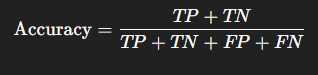

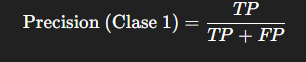

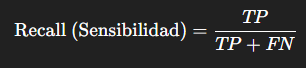

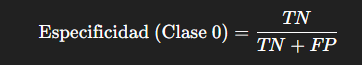

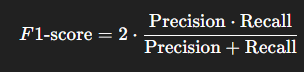

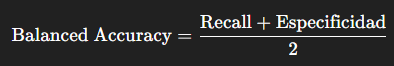

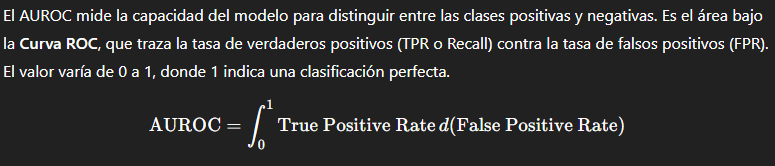

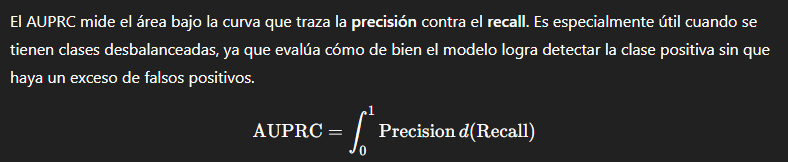

In [ ]:
#Confusion matrix TN / FP / FN / TP
cm  = confusion_matrix(labels_np, preds)
tn, fp, fn, tp = cm.ravel()

# Metricas basicas solicitadas
acc      = accuracy_score(labels_np, preds)
prec     = precision_score(labels_np, preds, zero_division=0)
recall1  = recall_score(labels_np, preds)                 #Sensibilidad clase 1
spec0    = tn / (tn + fp) if (tn + fp) else 0            #Especificidad clase 0
f1       = f1_score(labels_np, preds, zero_division=0)
bal_acc  = balanced_accuracy_score(labels_np, preds)
auc_roc  = roc_auc_score(labels_np, probs_test)           #Curva ROC
auprc    = average_precision_score(labels_np, probs_test) #Curva P-R

# Tabla resumida
print(f"Accuracy               : {acc:.3f}") #Predicciones correctas (clase 1 y 0)
print(f"Precision (Clase 1)    : {prec:.3f}") #Predicciones correctas (clase 1)
print(f"Recall / Sens (Clase 1): {recall1:.3f}")
print(f"Especificidad (Clase 0): {spec0:.3f}")
print(f"F1-score (Clase 1)     : {f1:.3f}")
print(f"Balanced Accuracy      : {bal_acc:.3f}")
print(f"AUROC                  : {auc_roc:.3f}")
print(f"AUPRC                  : {auprc:.3f}")
print("Confusion matrix (TN, FP, FN, TP):", cm.ravel().tolist())

Accuracy               : 0.825
Precision (Clase 1)    : 0.901
Recall / Sens (Clase 1): 0.852
Especificidad (Clase 0): 0.753
F1-score (Clase 1)     : 0.876
Balanced Accuracy      : 0.802
AUROC                  : 0.876
AUPRC                  : 0.937
Confusion matrix (TN, FP, FN, TP): [207, 68, 107, 617]


In [ ]:
# Guardar checkpoint del ensamble con taus (usar cat_maps ya definido)
torch.save({
    'arch'        : 'ResNet18',
    'state_dicts' : [
        torch.load(p, map_location='cpu', weights_only=False)['model_state']
        for p in fold_ckpts
    ],
    'fusion'      : 'avg',

    # Umbrales (validacion/hold-out)
    'tau_opt'     : float(tau_opt),          # multimodal
    'tau_opt_img' : float(tau_opt_img),      # solo imagen
    'tau_by_k'    : {str(k): float(v) for k, v in (tau_by_k or {}).items()},

    # Mapping de categorias usado en entrenamiento
    'cat_maps'    : cat_maps,

    # Metricas
    'tau_first'   : tau_first,
    'metrics'     : {
        'acc'     : float(acc),
        'prec'    : float(prec),
        'f1'      : float(f1),
        'auc'     : float(auc_roc),
        'recall'  : float(recall1),
        'spec'    : float(spec0),
        'bal_acc' : float(bal_acc),
        'auprc'   : float(auprc),
    }
}, os.path.join(VFINAL_DIR, 'ResNet18_ensemble_holdout.pth'))

print(f"Checkpoint actualizado con taus y cat_maps guardado en: {VFINAL_DIR}")

Checkpoint actualizado con taus y cat_maps guardado en: /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18


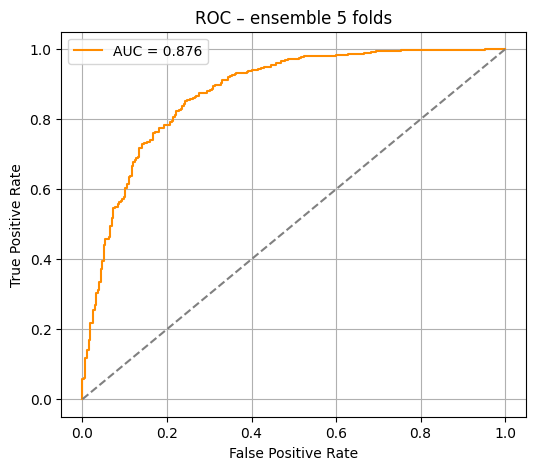

In [ ]:
fpr, tpr, thr = roc_curve(labels_test, probs_test)
roc_auc = sk_auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC – ensemble 5 folds')
plt.legend(); plt.grid(True); plt.show()

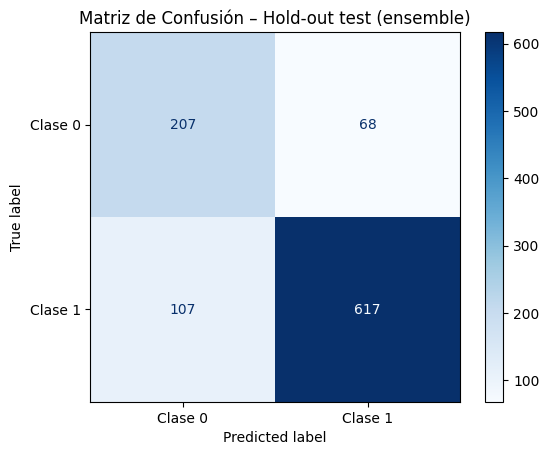

In [ ]:
cm = confusion_matrix(labels_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión – Hold-out test (ensemble)')
plt.grid(False)
plt.show()

# **Carpetas para guardar resultados de Grad-CAM**

In [ ]:
GRADCAM_DIR = Path(VFINAL_DIR) / "gradcam"
METRICS_DIR = GRADCAM_DIR / "metrics"   # CSVs
DOSSIER_DIR = GRADCAM_DIR / "dossier"   # imagenes y PDFs

METRICS_DIR.mkdir(parents=True, exist_ok=True)
DOSSIER_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
def load_model_for_gradcam():
    base = Path(VFINAL_DIR)

    # Intentar con el ensemble (usa el primer state_dict)
    ens_path = base / "ResNet18_ensemble_holdout.pth"
    state = None
    if ens_path.exists():
        ck_ens = torch.load(ens_path, map_location=device, weights_only=False)
        if isinstance(ck_ens.get("state_dicts", None), list) and len(ck_ens["state_dicts"]):
            state = ck_ens["state_dicts"][0]

    # Si no hay ensemble o esta vacio, elegir el mejor fold
    if state is None:
        best_p, best_ck, best_score = None, None, float("-inf")
        for p in sorted(base.glob("best_fold*.pth")):
            ck = torch.load(p, map_location=device, weights_only=False)
            score = ck.get("best_metric", ck.get("best_auc", float("-inf")))
            if score is None: score = float("-inf")
            if score > best_score:
                best_p, best_ck, best_score = p, ck, score
        if best_ck is None:
            raise FileNotFoundError("No encontré ni ensemble ni best_fold*.pth en VFINAL_DIR.")
        state = best_ck.get("model_state", best_ck.get("model_state_dict", None))
        if state is None:
            raise KeyError(f"{best_p} no contiene 'model_state' ni 'model_state_dict'.")

    # Construir el modelo e inyectar pesos
    model = MultimodalThyroidClassifier(
        tabular_input_dim=dataset[0][1].numel(),
        num_classes=1
    ).to(device)
    model.load_state_dict(state, strict=True)
    model.eval()

    # Seleccionar capa objetivo para ResNet-18
    if hasattr(model, "cnn") and hasattr(model.cnn, "layer4"):
        tgt = model.cnn.layer4[-1].conv2
    elif hasattr(model, "backbone") and hasattr(model.backbone, "layer4"):
        tgt = model.backbone.layer4[-1].conv2
    else:
        raise AttributeError("No pude localizar layer4 en tu backbone para Grad-CAM.")

    return model, tgt

model_final, target_layer = load_model_for_gradcam()

In [ ]:
# Helpers y CAM por ROI
target_layer = model_final.cnn.layer4[-1].conv2  # ultima conv de layer4
_norm_tf = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

def _parse_box_any(b, W, H):
    if b is None: return None
    if isinstance(b, str):
        b = b.strip()
        if not b or b.lower() in ('nan','none','null'): return None
        try: b = ast.literal_eval(b)
        except Exception: return None
    if not hasattr(b, '__len__') or len(b)!=4: return None
    x0,y0,x1,y1 = map(float, b)
    if max(x0,x1,y0,y1) <= 1.0:  # normalizada
        x0,x1 = x0*W, x1*W; y0,y1 = y0*H, y1*H
    x0 = max(0, min(int(round(x0)), W-1))
    y0 = max(0, min(int(round(y0)), H-1))
    x1 = max(x0+1, min(int(round(x1)), W))
    y1 = max(y0+1, min(int(round(y1)), H))
    return (x0,y0,x1,y1)

def get_roi_box_for_row(row, full_img, roi_source='meta', have_unet=False, unet=None, device='cpu'):
    W,H = full_img.size
    if roi_source=='meta':
        return _parse_box_any(row.get('box', None), W, H)
    elif roi_source=='unet' and have_unet and (unet is not None):
        try:
            box_pred, _, _ = unet_infer_box(unet, full_img, device=device, min_area=80, margin=0.10)
            return _parse_box_any(box_pred, W, H) if box_pred is not None else None
        except Exception:
            return None
    elif roi_source=='center':
        s = int(0.6*min(W,H))
        cx, cy = W//2, H//2
        x0 = max(0, cx - s//2); y0=max(0, cy - s//2)
        x1 = min(W, x0 + s);    y1=min(H, y0 + s)
        return (x0,y0,x1,y1)
    else:
        return None

# Metrica
def energy_in_roi(cam_full, gt_box):
    if gt_box is None: return np.nan
    H,W = cam_full.shape
    x0,y0,x1,y1 = gt_box
    x0 = max(0,min(x0,W-1)); x1=max(0,min(x1,W))
    y0 = max(0,min(y0,H-1)); y1=max(0,min(y1,H))
    if x1<=x0 or y1<=y0: return np.nan
    total = cam_full.sum() + 1e-8
    inside = cam_full[y0:y1, x0:x1].sum()
    return float(inside/total)

# CAM calculado con el CROP 224x224 del roi_source y pegado dentro de su caja
class _Proxy(torch.nn.Module):
    def __init__(self, base, clin_fixed):
        super().__init__()
        self.base = base; self.clin_fixed = clin_fixed
    def forward(self, x): return self.base(x, self.clin_fixed)

def _build_crop_224(full_img, box):
    """Recorta por box y produce el 224x224 que ve la red (resize→center-crop)"""
    if box is not None:
        full = full_img.crop(box).convert('RGB')
    else:
        full = full_img.convert('RGB')
    w,h = full.size; resize_to = 256
    if w <= h:
        new_w,new_h = resize_to, int(h*resize_to/w)
    else:
        new_h,new_w = resize_to, int(w*resize_to/h)
    img_res = full.resize((new_w,new_h), Image.BILINEAR)
    left = (new_w - 224)//2; top  = (new_h - 224)//2
    crop224 = img_res.crop((left, top, left+224, top+224))
    return crop224

def get_cam_for_idx_with_roi(idx_test_ds, roi_source, class_idx=None):
    """
    Devuelve: cam_full (H,W) en [0,1], pred, prob, gt_box (META), used_box (roi_source), full_RGB, row
    - El CAM se calcula con el crop definido por roi_source
    - Se pega dentro de used_box en un lienzo (W,H)
    - Las metricas se comparan contra gt_box = METADATO
    """
    orig_i = test_idx[idx_test_ds] if isinstance(test_idx, (list, np.ndarray)) else test_ds.indices[idx_test_ds]
    row = df.iloc[orig_i]
    img_path = row['img_path']
    full_L = Image.open(img_path).convert('L'); W,H = full_L.size
    full_RGB = full_L.convert('RGB')
    # cajas
    gt_box   = get_roi_box_for_row(row, full_L, roi_source='meta')  # ground truth coarse
    used_box = get_roi_box_for_row(row, full_L, roi_source=roi_source,
                                   have_unet=('unet' in globals() and (unet is not None)),
                                   unet=(unet if 'unet' in globals() else None),
                                   device=device)
    # crop 224 segun used_box
    crop224 = _build_crop_224(full_L, used_box)
    # tensores
    x = transforms.ToTensor()(crop224)
    x = _norm_tf(x).unsqueeze(0).to(device)
    # clinico fijo desde la fila
    cats = []
    for col in ['composition','echogenicity','margins','calcifications','sex']:
        try: cats.append(float(test_ds.cat_maps[col].get(row.get(col, None), 0)))
        except: cats.append(0.0)
    try: age = float(row.get('age', 0.0))
    except: age = 0.0
    clin_fixed = torch.tensor(cats + [age], dtype=torch.float32).unsqueeze(0).to(device)

    # Grad-CAM en rama imagen
    proxy = _Proxy(model_final, clin_fixed).to(device).eval()
    engine = GradCAM(proxy, target_layer)
    cam_crop, _ = engine(x, class_idx=None)   # [h,w] normalizado

    # pred/prob reales con el modelo original
    with torch.no_grad():
        logit = model_final(x, clin_fixed).squeeze()
        prob  = torch.sigmoid(logit).item()
        pred  = int(prob >= 0.5)

    cam_full = np.zeros((H, W), dtype=np.float32)
    if used_box is not None:
        x0,y0,x1,y1 = used_box
        cam_resized = np.array(
            Image.fromarray((cam_crop*255).astype('uint8')).resize((x1-x0, y1-y0), resample=Image.BILINEAR)
        ) / 255.0
        cam_full[y0:y1, x0:x1] = cam_resized
    else:
        # solo si no hay caja (raro), estira al full como fallback
        cam_full = np.array(Image.fromarray((cam_crop*255).astype('uint8')).resize((W, H), resample=Image.BILINEAR))/255.0

    if cam_full.max() > cam_full.min():
        cam_full = (cam_full - cam_full.min()) / (cam_full.max()-cam_full.min() + 1e-8)

    return cam_full, pred, prob, gt_box, used_box, full_RGB, row

In [ ]:
def eval_gradcam_on_test_PRO(roi_source='meta', save_csv_name='test_META.csv'):
    rows = []
    for i in range(len(test_ds)):
        cam_full, pred, prob, gt_box, used_box, full_rgb, row = get_cam_for_idx_with_roi(i, roi_source=roi_source)
        e_in = energy_in_roi(cam_full, gt_box)

        rows.append({
            'region_id': row.get('region_id', ''),
            'img_path' : row.get('img_path', ''),
            'label'    : int(row['label']),
            'pred'     : int(pred),
            'prob'     : float(prob),
            'roi_source': roi_source,
            'energy_in_roi': e_in,
        })

    out = pd.DataFrame(rows)
    if save_csv_name:
        save_path = METRICS_DIR / save_csv_name
        out.to_csv(save_path, index=False)
        print(f"Guardado {save_path} con {len(out)} filas")

    ok = out.dropna(subset=['energy_in_roi'])
    if len(ok):
        print(f"[{roi_source}] Energy-in-ROI global mean = {ok.energy_in_roi.mean():.3f}")
        print(f"[{roi_source}] Energy-in-ROI global median = {ok.energy_in_roi.median():.3f}")
    return out

m_meta   = eval_gradcam_on_test_PRO('meta',   'test_META.csv')
m_unet   = eval_gradcam_on_test_PRO('unet',   'test_UNET.csv')
m_center = eval_gradcam_on_test_PRO('center', 'test_CENTER.csv')

def _agg(df):
    if df is None or len(df) == 0:
        return pd.DataFrame()
    ok = df.dropna(subset=['energy_in_roi']).copy()
    if len(ok) == 0:
        return pd.DataFrame()

    ben = ok[ok['label'] == 0]
    mal = ok[ok['label'] == 1]

    def _mean_or_nan(sub):
        return float(sub['energy_in_roi'].mean()) if len(sub) else np.nan

    return pd.DataFrame([{
        'n_total' : len(ok),
        'n_benign': len(ben),
        'n_malign': len(mal),
        'acc'     : (ok['pred'] == ok['label']).mean(),
        'energy_mean_global' : ok['energy_in_roi'].mean(),
        'energy_mean_benign' : _mean_or_nan(ben),
        'energy_mean_malign' : _mean_or_nan(mal),
        'energy_median_global': ok['energy_in_roi'].median(),
    }])

overall = pd.concat([
    _agg(m_meta).assign(roi_source='META'),
    _agg(m_unet).assign(roi_source='UNET'),
    _agg(m_center).assign(roi_source='CENTER'),
], ignore_index=True)

print("\nENERGÍA POR FUENTE DE ROI")
display(overall)

Guardado /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/gradcam/metrics/test_META.csv con 999 filas
[meta] Energy-in-ROI global mean = 1.000
[meta] Energy-in-ROI global median = 1.000
Guardado /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/gradcam/metrics/test_UNET.csv con 999 filas
[unet] Energy-in-ROI global mean = 0.507
[unet] Energy-in-ROI global median = 0.555
Guardado /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/gradcam/metrics/test_CENTER.csv con 999 filas
[center] Energy-in-ROI global mean = 0.192
[center] Energy-in-ROI global median = 0.089

ENERGÍA POR FUENTE DE ROI


,n_total,n_benign,n_malign,acc,energy_mean_global,energy_mean_benign,energy_mean_malign,energy_median_global,roi_source
0,999,268,731,0.331331,1.000000,1.000000,1.000000,1.000000,META
1,999,268,731,0.304304,0.506967,0.439864,0.531568,0.554774,UNET
2,999,268,731,0.281281,0.192180,0.171763,0.199665,0.089224,CENTER


In [ ]:
# Dossier de imagenes
GRADCAM_DIR = Path(VFINAL_DIR) / "gradcam"
DOSSIER_DIR = GRADCAM_DIR / "dossier"
DOSSIER_DIR.mkdir(parents=True, exist_ok=True)

def _overlay(full_rgb, cam_full, alpha=0.35):
    cam_img = Image.fromarray((cam_full*255).astype('uint8')).resize(full_rgb.size, resample=Image.BILINEAR).convert('L')
    heat = Image.merge('RGB', (cam_img, Image.new('L', cam_img.size, 0), Image.new('L', cam_img.size, 0)))
    return Image.blend(full_rgb, heat, alpha)

def _draw_box(im, box, color=(0,255,0), width=3):
    if box is None: return im
    d = ImageDraw.Draw(im)
    d.rectangle([box[0], box[1], box[2], box[3]], outline=color, width=width)
    return im

def _annotate(im, lines, bg=(0,0,0), fg=(255,255,255)):
    try: font = ImageFont.truetype("arial.ttf", 18)
    except: font = ImageFont.load_default()
    d = ImageDraw.Draw(im)
    pad = 10
    text = "\n".join(lines)
    w,h = d.textbbox((0,0), text, font=font)[2:]
    box = [pad, pad, pad+w+14, pad+h+14]
    d.rectangle(box, fill=bg)
    d.text((pad+7, pad+7), text, fill=fg, font=font)
    return im

def _safe_region_id_from_test(j):
    """
    Devuelve el region_id del elemento j en test_ds, sin asumir .df.
    Intenta (1) df del dataset base, (2) devolverlo desde __getitem__.
    """
    # Caso A: test_ds es Subset y el dataset base tiene .df
    try:
        base = getattr(test_ds, 'dataset', None)
        if base is not None and hasattr(base, 'df') and hasattr(test_ds, 'indices'):
            base_idx = test_ds.indices[j]
            return base.df.iloc[base_idx]['region_id']
    except Exception:
        pass

    # Caso B: test_ds tiene .df directamente
    try:
        if hasattr(test_ds, 'df'):
            return test_ds.df.iloc[j]['region_id']
    except Exception:
        pass

    # Caso C: __getitem__ devuelve (img, clin, label, region_id, ...)
    try:
        sample = test_ds[j]
        if isinstance(sample, (list, tuple)) and len(sample) >= 4:
            return sample[3]
    except Exception:
        pass

    return None  # no se pudo

def _locate_in_test(region_id):
    """
    Devuelve el índice j dentro de test_ds cuyo region_id coincide.
    """
    for j in range(len(test_ds)):
        rid = _safe_region_id_from_test(j)
        if rid == region_id:
            return j
    return None

def select_5_5_cases(df, k_per_class=5):
    ok = df.dropna(subset=['energy_in_roi']).copy()
    ok['correct'] = (ok['pred'] == ok['label']).astype(int)
    ok = ok[ok['correct'] == 1]  # opcional: solo casos bien clasificados

    ben = ok[ok['label'] == 0].sort_values('energy_in_roi', ascending=False)
    mal = ok[ok['label'] == 1].sort_values('energy_in_roi', ascending=False)

    ben_sel = ben.head(k_per_class)
    mal_sel = mal.head(k_per_class)

    selected = pd.concat([ben_sel, mal_sel], ignore_index=True)
    print("Seleccionados:")
    display(selected[['region_id', 'label', 'pred', 'energy_in_roi']])

    # devolvemos la lista de region_id para reutilizarla en las tres fuentes de ROI
    return list(selected['region_id'])

def make_dossier_for_selected(roi_source_name, df_metrics, region_ids, make_pdf=True):
    roi_source = roi_source_name.lower()
    out_dir = DOSSIER_DIR / f"{roi_source_name}_10casos"
    out_dir.mkdir(parents=True, exist_ok=True)

    saved_paths = []

    for region_id in region_ids:
        rows = df_metrics[df_metrics['region_id'] == region_id]
        if rows.empty:
            continue
        rowm = rows.iloc[0]
        j = _locate_in_test(region_id)
        if j is None:
            continue

        cam_full, pred, prob, gt_box, used_box, full_rgb, row = get_cam_for_idx_with_roi(j, roi_source=roi_source)

        e_in = energy_in_roi(cam_full, gt_box)

        vis = _overlay(full_rgb, cam_full, alpha=0.35)
        vis = _draw_box(vis, gt_box,   color=(0,255,0),   width=4)   # GT
        vis = _draw_box(vis, used_box, color=(255,215,0), width=3)   # ROI usada

        label_str = "Maligno" if int(rowm['label']) == 1 else "Benigno"

        lines = [
            f"{roi_source_name} | {label_str}",
            f"{region_id} | L={int(rowm['label'])} P={int(pred)} prob={prob:.2f}",
            f"E_in={e_in:.2f}",
        ]
        vis = _annotate(vis, lines)

        fname = f"{roi_source_name}_{region_id}.png"
        path_out = out_dir / fname
        vis.save(path_out)
        saved_paths.append(path_out)

    if make_pdf and saved_paths:
        imgs = [Image.open(p).convert("RGB") for p in saved_paths]
        pdf_path = DOSSIER_DIR / f"dossier_{roi_source_name}_10casos.pdf"
        imgs[0].save(pdf_path, save_all=True, append_images=imgs[1:])
        print(f"PDF generado: {pdf_path}")

    print(f"Dossier {roi_source_name}: {len(saved_paths)} imágenes en {out_dir}")

In [ ]:
selected_region_ids = select_5_5_cases(m_meta, k_per_class=5)

if 'selected_region_ids' in globals():
    if len(m_meta):   make_dossier_for_selected('META',   m_meta,   selected_region_ids, make_pdf=True)
    if len(m_unet):   make_dossier_for_selected('UNET',   m_unet,   selected_region_ids, make_pdf=True)
    if len(m_center): make_dossier_for_selected('CENTER', m_center, selected_region_ids, make_pdf=True)

Seleccionados:


,region_id,label,pred,energy_in_roi
0,003573_bb1,0,0,1.0
1,000048_bb1,0,0,1.0
2,000202_bb1,0,0,1.0
3,000223_bb1,0,0,1.0
4,000651_bb1,0,0,1.0
5,004248_bb1,1,1,1.0
6,001456_bb1,1,1,1.0
7,004456_bb1,1,1,1.0
8,003246_bb1,1,1,1.0
9,003975_bb1,1,1,1.0


PDF generado: /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/gradcam/dossier/dossier_META_10casos.pdf
Dossier META: 10 imágenes en /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/gradcam/dossier/META_10casos
PDF generado: /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/gradcam/dossier/dossier_UNET_10casos.pdf
Dossier UNET: 10 imágenes en /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/gradcam/dossier/UNET_10casos
PDF generado: /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/gradcam/dossier/dossier_CENTER_10casos.pdf
Dossier CENTER: 10 imágenes en /content/drive/MyDrive/DSP_Alvaro_Esparza/pths/ResNet18/gradcam/dossier/CENTER_10casos
